# Yet Another OpenPose 

---
## Environment

In [4]:
#verify user
!whoami
#which Environment/virtualenv running in
import sys
import os

print("Python running from:",sys.prefix)
print("Current working dir",os.getcwd())

conex
Python running from: /home/conex/anaconda3/envs/openpose
Current working dir /home/conex/OpenPose/training


---
## Config

In [5]:
!export PYTHONPATH=/home/conex/Yet-Another-Openpose-Implementation/:$PYTHONPATH
import sys
sys.path.append("..")

from configs import default_config as cfg

#import local_storage_config as storage_cfg
from configs import local_storage_config as storage_cfg
cfg.__dict__.update(storage_cfg.__dict__)

In [6]:
from utils import now
nowt=now()

import tensorflow as tf
print("Tensorflow version:",tf.version.VERSION)

Tensorflow version: 2.1.0


In [7]:
import datetime
import numpy as np

import dataset_functions
import models.six_stage_linear_model as model
import callbacks
import dataset_builder
import load_weights
import loss_metrics

In [8]:
# import importlib as il
# il.reload() #useful to reload any changes

---
## Dataset

In [9]:
# Training settings
TRAINING_EPOCHS = 30
REAL_EPOCH_STEPS = int(cfg.DATASET_SIZE / cfg.BATCH_SIZE)
SHORT_EPOCH_STEPS=50 #actual epocsh used in training, smaller than real epoch, but allows to track progress better, [in batches]
SHORT_TRAINING_EPOCHS=int(TRAINING_EPOCHS*(REAL_EPOCH_STEPS/SHORT_EPOCH_STEPS))
SHORT_VALIDATION_STEPS=5 #per short epoch

EPOCH_RATIO=int(REAL_EPOCH_STEPS / SHORT_EPOCH_STEPS)
# adam_learning_rate=0.001  #for reference
BASE_LEARNING_RATE = 0.0001
LEARNING_RATE_SCHEDUELE = np.zeros(100000)  #used with short epochs
LEARNING_RATE_SCHEDUELE[:3 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[3 * EPOCH_RATIO:20 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[20 * EPOCH_RATIO:40 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[40 * EPOCH_RATIO:100 * EPOCH_RATIO] = 0.5
LEARNING_RATE_SCHEDUELE[100 * EPOCH_RATIO:] = 0.3
LEARNING_RATE_SCHEDUELE *= BASE_LEARNING_RATE

In [10]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: /home/conex/OpenPose/mydata/training
Retrieving TFrecords from: /home/conex/OpenPose/mydata/validation
Found the following training TFrecords:
 /home/conex/OpenPose/mydata/training-001.tfrecords
/home/conex/OpenPose/mydata/training-002.tfrecords
/home/conex/OpenPose/mydata/training-003.tfrecords
Found the following validation TFrecords:
 /home/conex/OpenPose/mydata/validation-001.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 

In [11]:
#Test element
dst_iter=iter(dst)
sample_elem=next(dst_iter)
print("Dataset shape:",dst) #this should match the model input, and output stages

Dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


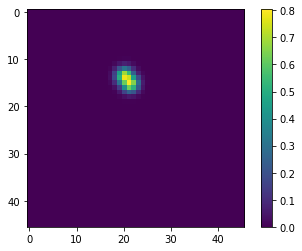

In [12]:
#testing mask
sample_elem=next(dst_iter)
m=sample_elem[1][1][0,...,0]
import matplotlib.pyplot as plt
plt.imshow(m)
plt.colorbar()

---
## Model
### Load weights

In [13]:
if cfg.ASK_FOR_CHECKPOINTS:
    checkpoint,starting_epoch=load_weights.checkpoints_prompt(cfg)
else:
    checkpoint=None
    starting_epoch=0

Found no checkpoints


### Build Model

In [14]:
model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model
def define():
    train_model,test_model=model_maker.create_models()
    
#     if cfg.INCLUDE_MASK:
#         losses=[loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanSquaredError()
#                 ,loss_metrics.MaskedMeanSquaredError()]                      
#     else:
#         raise NotImplementedError       
    
    #this must match the model output order
    metrics=[
              [loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]    
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
        ]
    
    train_model.compile(
                    optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE)                   
                    ,loss=loss_metrics.MaskedMeanSquaredError()
                    ,loss_weights=[5,5,5,5,1,1]
                    ,metrics=metrics                           
                   )
    print('done')
    return train_model,test_model


train_model,test_model=define()
if (checkpoint):
    print('checkpoint')
    train_model.load_weights(checkpoint)

done


### Callbacks

In [15]:
all_callbacks=[
    callbacks.make_LRscheduler_callback(LEARNING_RATE_SCHEDUELE)
    ,callbacks.PrintLR()
    ,tf.keras.callbacks.TerminateOnNaN()
]
if cfg.SAVE_CHECKPOINTS:
    checkpoints_path, checkpoint_callback=callbacks.make_checkpoint_callback(cfg,nowt,REAL_EPOCH_STEPS*cfg.BATCH_SIZE)
    all_callbacks.append(checkpoint_callback)
if cfg.SAVE_TENSORBOARD:
    tensorboard_path, tensorboard_callback=callbacks.make_tensorboard_callback(cfg,nowt,EPOCH_RATIO)
    all_callbacks+=[tensorboard_callback]

checkpoints_path: /home/conex/OpenPose/trained/checkpoints/test01Thu0421-1547/-E{epoch:04d}.ckpt
tensorboard_path: /home/conex/OpenPose/trained/tensorboard/test01Thu0421-1547


In [16]:
#run to clean all tensorboard&checkpoints results
!gsutil -m rm -r {cfg.TENSORBOARD_PATH}/*
!gsutil -m rm -r {cfg.CHECKPOINTS_PATH}/*

/bin/bash: gsutil: command not found
/bin/bash: gsutil: command not found


In [17]:
#start tensor board
# must run 
#/usr/local/bin/tensorboard serve --logdir gs://dl_training_results/tensorboard --port 8889 --bind_all
%load_ext tensorboard
%tensorboard --logdir=/home/conex/OpenPose/trained/tensorboard/test01Thu0421-1547

---
## Training
Actually training

In [ ]:
train_history=train_model.fit(
    dst
    ,epochs=SHORT_TRAINING_EPOCHS
    ,steps_per_epoch=SHORT_EPOCH_STEPS
    ,validation_steps=SHORT_VALIDATION_STEPS
    ,validation_data=dsv
    ,callbacks=all_callbacks
    ,initial_epoch=starting_epoch
)

Train for 50 steps, validate for 5 steps

Learning rate for epoch 0 is 9.999999747378752e-05
Epoch 1/600


In [ ]:
#run to clear this run results
#!gsutil -m rm -r {tensorboard_path}/*
#!gsutil -m rm -r {checkpoint_path}/*

---
### Save results

In [19]:
tmp_path='./temp_weights'
train_model.save_weights(tmp_path)

local_model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

cpu_train_model,cpu_test_model=local_model_maker.create_models()

cpu_train_model.load_weights(tmp_path)
cpu_test_model.load_weights(tmp_path)

cpu_test_model.save(cfg.MODELS_PATH+"/test_"+cfg.RUN_NAME+nowt,include_optimizer=False) 
cpu_train_model.save(cfg.MODELS_PATH+"/train_"+cfg.RUN_NAME+nowt,include_optimizer=False) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/conex/Yet-Another-Openpose-Implementation/trained/models/test_test01Thu0421-1425/assets
INFO:tensorflow:Assets written to: /home/conex/Yet-Another-Openpose-Implementation/trained/models/train_test01Thu0421-1425/assets
